# 총 4가지 시각화 
- 원하는 이미지와 mask 출력 (복수 가능)
- annotation area 크기 작은 순서, 큰 순서 정렬 출력 
- 원하는 이미지와 이미지의 특정 카테고리 mask 출력 
- 하나의 이미지 해당하는 모든 annotation mask 출력  

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

#utils
from typing import Union
from typing import List
import random

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [2]:
%matplotlib inline

dataset_path  = '../../data'
anns_file_path = dataset_path + '/' + 'train_all_new.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)
cat_names = [cat['name'] for cat in categories]

print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)


Number of categories: 10
Number of annotations: 26931
Number of images: 3467


In [57]:
df

Categories  Number of annotations
1          Paper                   9481
7    Plastic bag                   7783
5        Plastic                   3199
0  General trash                   2906
6      Styrofoam                   1376
2     Paper pack                    683
4          Glass                    625
3          Metal                    616
9       Clothing                    192
8        Battery                     70

In [3]:
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1
    
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)



In [4]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

category_names = list(sorted_df.Categories)

coco = COCO(anns_file_path)
category_names = list(sorted_df.Categories)

loading annotations into memory...
Done (t=4.27s)
creating index...
index created!


In [5]:
data = []
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

anns = dataset['annotations']

data = [ann['image_id'] for ann in anns]
data2 = [ann['id'] for ann in anns]
data3 = [ann['area'] for ann in anns]
data4 = [ann['category_id']for ann in anns]

df = pd.DataFrame({'image_id': data, 'id': data2, 'area': data3, 'category_id': data4})


In [6]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def category_id_to_color(category_id):
    return plt.cm.gist_ncar(np.linspace(0, 1.0, 11)[category_id])[:3]


def show_coco(idx: Union[int, List[int]], ids: Union[int, List[int]] = None, size: str = None) -> None:
    """
    input 
    idx: Union[int, List[int]]
    size: str = None 
    size if for print size of area 
    """
    if type(idx) == int: idx = [idx]
    num = len(idx)
    if not size is None:
        _tmp = 3
        fig, axes = plt.subplots(num, _tmp, figsize=(20, 8*num)) # 1장 9 
    else:
        _tmp = 2
        fig, axes = plt.subplots(num, _tmp,figsize=(20, 8*num)) # 1장 9 

    axes = axes.flatten()


    for i, (img, id) in enumerate(zip(idx,ids)):
        pixel_lst = []
        leg_titles = []
        minmax_leg_titles = []
        leg_colors = []
        minmax_leg_colors = []

        image_infos = coco.loadImgs(img)[0]
        catIds = coco.getCatIds()
        cats = coco.loadCats(catIds)

        ann_ids = coco.getAnnIds(imgIds=image_infos['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        masks = np.zeros((image_infos["height"], image_infos["width"], 3))
        for ann in anns:
            className = get_classname(ann['category_id'], cats)
            color = category_id_to_color(category_names.index(className))
            masks[coco.annToMask(ann) == 1] = color#category_names.index(className)
            if className not in leg_titles:
                leg_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
                leg_titles.append(className) 

        if not size is None:
            minmax_masks = np.zeros((image_infos["height"], image_infos["width"], 3))
            
            #ann = min(anns, key= lambda ann: ann['area']) if size == "min" else max(anns, key= lambda ann: ann['area'])
            ann = coco.loadAnns(id)
            className = get_classname(ann[0]['category_id'], cats)
            color = category_id_to_color(category_names.index(className))
            minmax_masks[coco.annToMask(ann[0]) == 1] = color#category_names.index(className)
            minmax_leg_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
            minmax_leg_titles.append(className) 
        

        tmp_images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        tmp_images = cv2.cvtColor(tmp_images, cv2.COLOR_BGR2RGB).astype(np.float32)
        tmp_images /= 255.0


        axes[i*_tmp].imshow(tmp_images)
        axes[i*_tmp].grid(False)
        axes[i*_tmp].set_title("input image : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)

        axes[i*_tmp+1].imshow(masks)
        axes[i*_tmp+1].grid(False)
        axes[i*_tmp+1].set_title("masks : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)
        axes[i*_tmp+1].legend(leg_colors, leg_titles, loc='lower right', framealpha=.5)

        if not size is None:
            axes[i*_tmp+2].imshow(minmax_masks)
            axes[i*_tmp+2].grid(False)
            axes[i*_tmp+2].set_title("minmax_masks : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)
            axes[i*_tmp+2].legend(minmax_leg_colors, minmax_leg_titles, loc='lower right', framealpha=.5)

    plt.show()




In [7]:
area = 31.5
prob = area/(512*512) * 100
print(f"{round(prob,5)} %")

0.01202 %


In [10]:
df.sort_values("area").iloc[40:50]

#50정도까지 지우기 

image_id     id  area  category_id
16107      1935  16202  29.0            1
4978       1001   5037  29.0            2
19434      2144  19544  29.0            2
18306      2056  18413  29.0            3
17137      1986  17240  29.5            3
9227       1365   9299  29.5            1
20629      2269  20739  30.0            2
23532      2521  23662  30.0            6
23424      2509  23554  30.5            2
7919       1269   7983  31.0            2

## 시각화 
#### `mode = 0`
- 원하는 index 출력 (다중 선택 출력 가능)
- 이하 중 선택 
    - single (id: int) 
    - multiple (id: List[int])
    - random (id: List[int])
- ex) idx = 1 or idx = [1,2,3,4,5] or idx = random.sample(range(1,100),10)

#### `mode = 1`
- area 크기 내림차순, 오름차순 출력
- "출력방식 (size: str)"
    - size ["max", "min"] 중 선택

#### `mode = 2`
- Category 별 출력 , area 크기 내림차순, 오름차순 출력
- "Category (category: str)", 
    - category ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing'] 중 선택
- "출력방식 (size : str)"
    - size ["max", "min"] 중 선택




[3143, 969, 3130, 1357, 3244, 1287, 3210, 819, 128, 752, 2031, 3189, 3190, 3141, 2087, 2748, 744, 762, 2027, 2736]


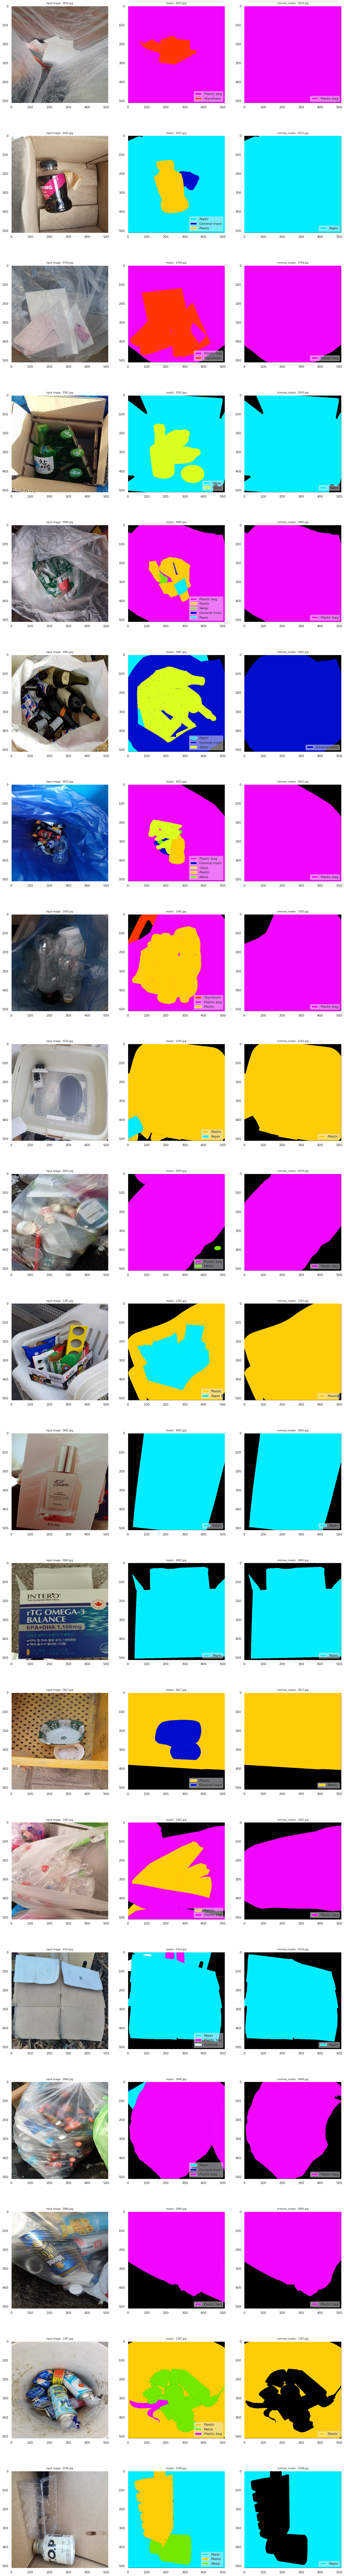

In [9]:
categories = cat_names
size = None
ids = None 

#Hyperparameter

#index: 0 , size순: 1, category 순: 2
mode = 1

#index 
if mode == 0:
    size = None
    idx = [2000, 2001] 

#크기순 
elif mode == 1:
    size = "max"

#category 크기순 
else:
    category = "Battery" 
    size = "min"



if mode == 0:
    assert size == None and ids == None
    idx = [20000,20010]
elif mode == 1:
    tmp = df.sort_values("area").iloc[40:50] if size is "min" else df.sort_values("area", ascending=False).iloc[:20]
    idx = tmp["image_id"].tolist()
    ids = tmp["id"].tolist()
    print(idx)
else: 
    condition = df.category_id == categories.index(category) + 1
    tmp = df[condition].sort_values("area").iloc[:20] if size is "min" else df[condition].sort_values("area", ascending="False").iloc[:10]
    idx = tmp["image_id"].tolist()
    ids = tmp["id"].tolist()

show_coco(idx, ids, size)


#중복해서 뜨는 경우 (작은 물체가 img안에 여러개 존재)
#image_id 와 file_name은 원래 다릅니다. 


### image 별 annotation 출력
- `idx` 에 이미지 id 를 입력

In [ ]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def category_id_to_color(category_id):
    return plt.cm.gist_ncar(np.linspace(0, 1.0, 11)[category_id])[:3]


def show_coco(idx: int) -> None:
    """
    input 
    idx: Union[int, List[int]]
    size: str = None 
    size if for print size of area 
    """    

    image_infos = coco.loadImgs(idx)[0]
    catIds = coco.getCatIds()
    cats = coco.loadCats(catIds)

    ann_ids = coco.getAnnIds(imgIds=image_infos['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    cat_nums = [ann["category_id"] for ann in anns]
    
    

    
    tmp_images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    tmp_images = cv2.cvtColor(tmp_images, cv2.COLOR_BGR2RGB).astype(np.float32)
    tmp_images /= 255.0

    num = len(cat_nums)
    left =  num//5 + 1
    print(len(anns))

    fig, axes = plt.subplots(left, 6, figsize=(20, 4 * left)) # 1장 9 
    axes = axes.flatten()
    masks = np.zeros((image_infos["height"], image_infos["width"], 3))

    for idx, ann in enumerate(anns):
        leg_titles = []
        leg_colors = []
        tmp_masks = np.zeros((image_infos["height"], image_infos["width"], 3))
        cat_num = ann["category_id"]

        className = get_classname(ann['category_id'], cats)
        color = category_id_to_color(category_names.index(className))
        tmp_masks[coco.annToMask(ann) == 1] = color#category_names.index(className)
        masks[coco.annToMask(ann) == 1] = color#category_names.index(className)
        
        if className not in leg_titles:
            leg_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
            leg_titles.append(className) 
        axes[idx+1].imshow(tmp_masks)
        axes[idx+1].grid(False)
        axes[idx+1].set_title("input mask : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)
        axes[idx+1].legend(leg_colors, leg_titles, loc='lower right', framealpha=.5)
    
    #original image
    axes[0].imshow(tmp_images)
    axes[0].grid(False)
    axes[0].set_title("input image : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)
    #overall mask 
    axes[idx+2].imshow(masks)
    axes[idx+2].grid(False)
    axes[idx+2].set_title("overall mask : {}".format(image_infos['file_name'].split('/')[1]), fontsize = 8)
    axes[idx+2].legend(leg_colors, leg_titles, loc='lower right', framealpha=.5)


       
    plt.show()

16


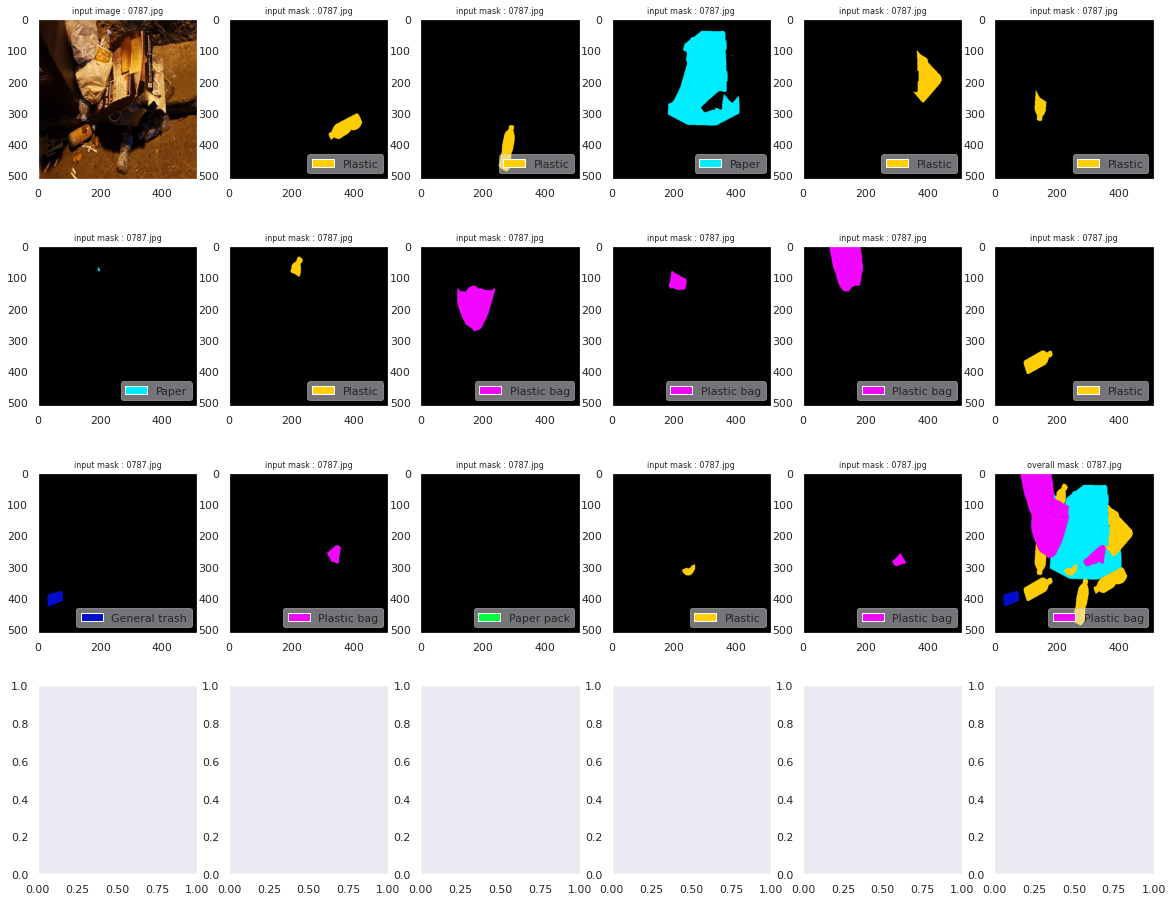

In [47]:
categories = cat_names
size = None
ids = None 
idx = 1552
#[2015, 1662, 1552
show_coco(idx)